In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('seaborn')

C:\Users\loloi\AppData\Local\Temp\ipykernel_5152\4218658691.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Quantum tunneling of a Gaussian wavepacket

The method we're going to use for this animation is exactly the same than in my video on the *Time-Dependent Schrödinger equation.*
The steps are the following: 

* Discretise space by creating an $N$ point grid. 

* Create the initial wavefunction at time $t=0$, which will be a Gaussian wavepacket of the form:

$$\Psi(x,t=0) \propto e^{- \frac{(x-x_0)^2}{2 \sigma^2}} e^{i k_0 x}, $$

where $x_0$ is the inital center of the wavepacket, $k_0$ is the inital momentum and $\sigma$ is the initial spread or variance of the wavepacket. 

* Find the energies and eigenfunctions from the *Time-Independent Schrödinger equation*: 

$$ \left[-\frac{\hbar^2}{2m} \frac{d^2 \psi}{ dx^2} + V(x) \right] = E \psi $$

where $V(x) = \begin{cases} V_0 \text{ for } a \leq x \leq a+w \\ 0 \text { otherwise } \end{cases} $ and the differential operator $\frac {d^2}{dx^2}$ can be approximated by the following matrix using finite difference methods (see[]): 


$$ \frac {d^2}{dx^2} = \frac 1{\Delta_x^2} \begin{pmatrix} -2 && 1&&0&&0&& \ldots \\ 1 &&-2&&1 && 0&& \ldots \\ \vdots && \ddots && \ddots &&  \ddots && \ddots \\ 0 &&\ldots && \ldots && 1 &&-2 \end{pmatrix} $$ 

where $\Delta_x$ is the grid point spacing.

* Normalise the eigenfunctions using: $\int_0^L \psi_n(x) dx \approx \sum_i \psi(x_i) \Delta_x = 1$

* Then, since our eigenfunctions from an orthonormal basis, we can expand $\Psi(x,t=0)$ in the basis of the $\psi_n(x)$:

$$\Psi(x,t=0) = \sum_n c_n \psi_n(x) \Rightarrow c_m = \int_0^L \psi_m^{\ast}(x) \Psi(x,t=0) dx$$

* Finally, we apply the time evolution operator to get the time evolution of our wavefunction: 

$$\Psi(x,t) = \sum_n c_n e^{-i E_n t/ \hbar} \psi_n(x).$$


**Remarks:** 

* An important point is the boundary conditions of the system. Because our grid is finite, the wavefunction must be 0 at the endpoints **so we only consider the range of indices $i=1, 2, ... N-1$ when doing the computations**. 

* The units we will use are atomic units: $\hbar \to 1$ and $m_e \to 1$. 

In [2]:


class Gaussian_Wave:
    
    def __init__(self, N_grid, L, a, V0, w, x0, k0,sigma,t):
        
        self.t=t
        self.L=L
        self.N_grid = N_grid
        
        self.x = np.linspace(0,self.L,self.N_grid+1) #grid of points
        self.dx = self.x[1]-self.x[0] #grid point spacing or 'discrete' analogue of the differential length
        
        
        def integral(f,axis = 0):
            """This function allows us to approximate integrals in discrete space"""
            return np.sum(f*self.dx, axis = axis)
        
        
        self.Psi0  = np.exp( -1/2* (self.x[1:-1]-x0)**2/sigma**2) *np.exp(1j*k0*self.x[1:-1]) 
        #use this range for x because as mentionned, we need the wavefunction to be 0 at the endpoints of the grid. 
        
        
        #normalise the initial state
        norm  = integral(np.abs(self.Psi0)**2)
        self.Psi0 = self.Psi0/np.sqrt(norm)
        
        #kinetic energy
        self.T = -1/2 * 1/self.dx**2 * (np.diag(-2*np.ones(self.N_grid-1))+ np.diag(np.ones(self.N_grid-2),1)+ np.diag(np.ones(self.N_grid-2),-1))
        print(self.T.shape)
        
        #potential as a flat array
        self.V_flat = np.array([V0 if a< pos < a+w else -0.01 for pos in self.x[1:-1]])
        
        #potential energy as a diagonal matrix
        self.V = np.diag(self.V_flat)
        
        #Hamiltonian
        self.H = self.T+self.V
        
        
    #solve the eigenvalue problem and get the time-dependent wavefunction   
    def animation(self):
        
        
        def integral(f,axis = 0):
            """This function allows us to approximate integrals in discrete space"""
            return np.sum(f*self.dx, axis = axis)
            
            
        #get eigenvalues and eigenvectors and normalise
        E, psi = np.linalg.eigh(self.H)
        psi = psi.T
        norm = integral(np.abs(psi)**2)
        psi = psi/np.sqrt(norm)

        #get expansion coeffs
        c_n = np.zeros_like(psi[0], dtype=complex)
        for j in range(0, self.N_grid-1):

            c_n[j] = integral(np.conj(psi[j]) * self.Psi0) #for each eigenvector, compute the inner product

        #get a function that returns the time dependent wavefunction
        def Psi(t):
            
            return psi.T@(c_n*np.exp(-1j*E*t))





        fig = plt.figure(figsize = (20,12))
        ax = plt.axes(xlim=(0, self.L), ylim=(-0.25, 0.25))
        line, = ax.plot([], [], lw=2)
        ax.plot(self.x[1:-1],self.V_flat, label = '$V(x)$')
        ax.set_title('Gaussian wave packet with a potential barrier', fontsize = 20)
        line1, = ax.plot(self.x[1:-1],np.zeros(self.N_grid-1),lw=2,color="red", label = '$\Re(\psi)$')
        line2, = ax.plot(self.x[1:-1],np.zeros(self.N_grid-1),lw=2,color="blue", label = '$\Im(\psi)$')
        ax.legend(fontsize = 15)
        ax.set_xlabel('$x$', fontsize = 15)

        def animate(t):

            y1 = np.real(Psi(t))
            y2 = np.imag(Psi(t))
            line1.set_data(self.x[1:-1],y1)  
            line2.set_data(self.x[1:-1], y2)

            return (line1, line2,)


        def init():
            line1.set_data([],[])  
            line2.set_data([], [])
            return (line1,line2,)

        ani = FuncAnimation(fig, animate, len(self.t), init_func=init,
                                      interval=20, blit=False)
        
        return ani

            
            
            
            
            
            
            
        
        
        

(749, 749)


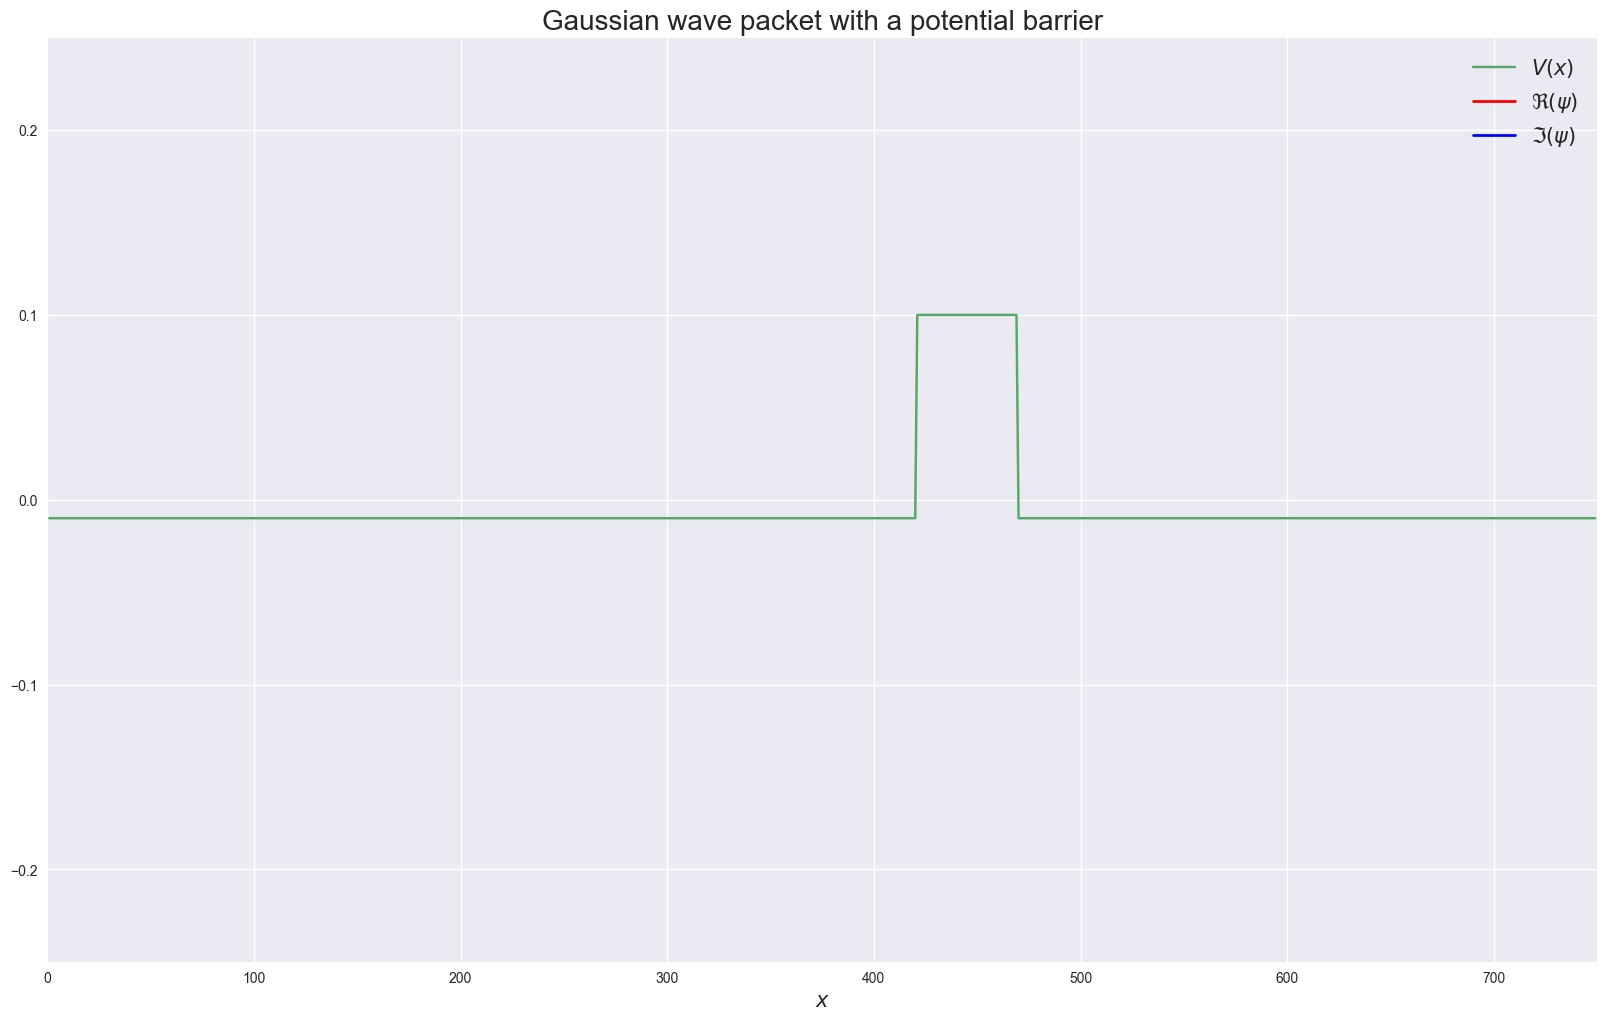

In [3]:
wavepacket = Gaussian_Wave(750,750, 420,0.1,50,100,0.4,15, np.linspace(0.,2500,1000))
Psi = wavepacket.animation()
HTML(Psi.to_html5_video())